# IOD_lifecycle: temporal evolution of SST anomalies in the equatorial Indian Ocean
Computes the temporal root mean square error (RMSE) of the Dipole Mode Index (gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern Indian Ocean (90E-110E and 10S-0N) between model and observations. The analysis spans 6 years centred on IOD peak years to evaluate the ability of the model to capture the full lifecycle of IOD events, including onset, peak, and decay phases.

# Datasets Used for Temporal Evolution Comparison¶
The following reference datasets are employed to evaluate the IOD lifecycle in model simulations:
- **HadISST (1870–2018)**: A comprehensive dataset of SST and sea ice, blending historical observations with reconstructions.

Additional datasets include:
- **ERSSTv5 (1854–2018)**: A globally gridded SST anomaly dataset optimised for long-term climate monitoring and iod analysis.


## Dask Cluster
Start a cluster

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41963,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41915,Total threads: 1
Dashboard: /proxy/44433/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:34725,


In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='tos',
    project='CMIP6',
    mip="Omon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20141231",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='tos',
    dataset='HadISST',
    mip="Omon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20141231",
    tier=2),
"ERSSTv5":
    Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="19790101/20141231",
    tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftof', mip="Ofx")
    dataset.add_supplementary(short_name="areacello", mip="Ofx")

In [5]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


In [7]:
def sst_iod_dmi(cube):

    iod_east = {"start_longitude": 90., "end_longitude": 110., "start_latitude": -10., "end_latitude": 0.}
    iod_west = {"start_longitude": 50., "end_longitude": 70., "start_latitude": -10., "end_latitude": 10.}
    
    cube = convert_units(cube, units="degC")
    cube = detrend(cube, dimension="time", method="linear")
    cube_west = extract_region(cube, **iod_west)
    cube_east = extract_region(cube, **iod_east)

    # remove seasonal cycle
    cube_west = anomalies(cube_west, period='monthly')
    cube_east = anomalies(cube_east, period='monthly')

    cube_west = area_statistics(cube_west, operator='mean')
    cube_east = area_statistics(cube_east, operator='mean')
    
    cube_dmi = cube_west - cube_east

    return cube_dmi


def sst_meridional(cube): ##along latitude for area
    io_trop = {"start_longitude": 50., "end_longitude": 110., "start_latitude": -10., "end_latitude": 10.}
    cube = convert_units(cube, units="degC")
    cube = anomalies(cube, period='monthly')
    cube = extract_region(cube, **io_trop)
    
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = meridional_statistics(cube,operator='mean')
    return cube

#rmse

In [8]:
model_datasets_prep1 = {name: sst_iod_dmi(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_iod_dmi(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/cube.py:4343: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


In [9]:
from iris.util import rolling_window

def sst_regressed(dmi_cube, dmi_area): 
    """Regression function for both 1d and area for lifecycle epochs."""
    dmi_sep = extract_month(dmi_cube, 9)
    # 6 year epoch: [yr-2, yr-1, yr, yr+1, yr+2, yr+3] with monthly data (12) # exclude first year
    dmi_area_sel = rolling_window(dmi_area[12:].data, window=6*12, step=12, axis=0) #2d
    a_data = dmi_area_sel.reshape(dmi_area_sel.shape[0], -1)
    
    # not first 2 or last 3 years for epochs # also exclude first year, leadlagyr=3
    b_data = dmi_sep[3:-3].data
    b_with_intercept = np.vstack([b_data, np.ones_like(b_data)]).T    

    # 2 area linear regression
    coefs_area, _, _, _ = np.linalg.lstsq(b_with_intercept, a_data, rcond=None)
    slope_area = coefs_area[0].reshape(dmi_area_sel.shape[1], dmi_area_sel.shape[2])
    
    return slope_area

In [10]:
model_dmi = model_datasets_prep1["ACCESS-ESM1-5"]
model_dmi_area = model_datasets_prep2["ACCESS-ESM1-5"]

obs_dmi = obs_datasets_prep1["HadISST"]
obs_dmi_area = obs_datasets_prep2["HadISST"]


In [11]:
## metric computation - rmse of slopes

model = sst_regressed(model_dmi, model_dmi_area)

## obs
obs = sst_regressed(obs_dmi, obs_dmi_area)

rmse = np.sqrt(np.mean((obs[0] - model[0]) ** 2))
rmse


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/scipy/linalg/_basic.py:1512: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0.03245827

# Diagnostic Level 1
This shows the broader picture to better understand the spatial-temporal pattern of IOD: the Hovmöller of the anomalies in the equatorial Indian Ocean.

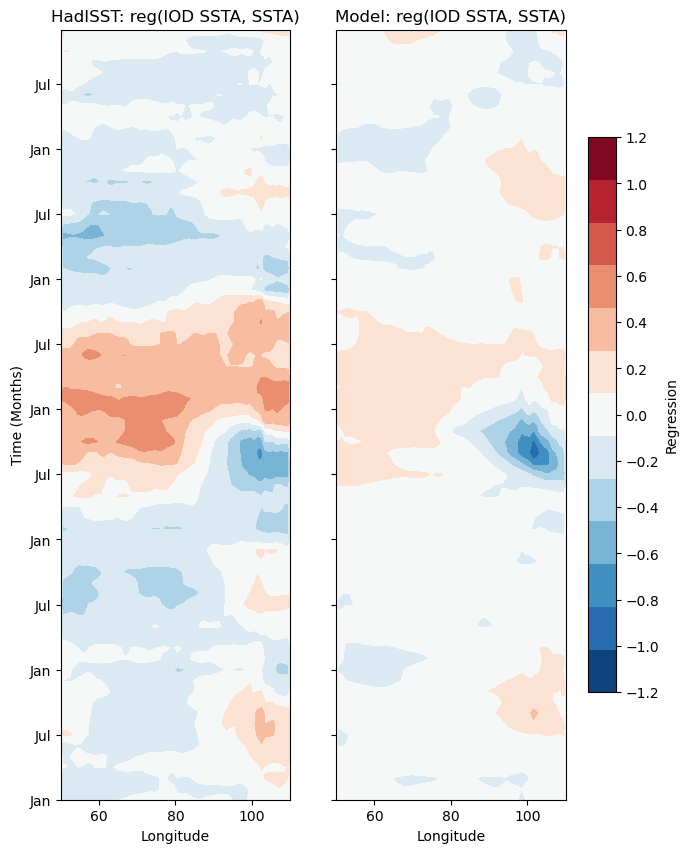

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom ticks for the y-axis (every 6 months)
yticks = range(1, 73, 6)
ytick_labels = ['Jan', 'Jul'] * (len(yticks) // 2)

# Define shared color limits for both subplots
vmin = -1.2 # min(np.min(slope_area), np.min(obs_slope_area))
vmax = 1.2 # max(np.max(slope_area), np.max(obs_slope_area))

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 10), sharey=True)

# First subplot
c1 = ax1.contourf(obs_dmi_area.coord('longitude').points, range(1, 73), obs,
                  cmap='RdBu_r', levels=np.linspace(vmin, vmax, 14))
ax1.set_ylabel('Time (Months)')
ax1.set_xlabel('Longitude')
ax1.set_xlim([50,110])
ax1.set_title('HadISST: reg(IOD SSTA, SSTA)')
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytick_labels)

# Second subplot
c2 = ax2.contourf(model_dmi_area.coord('longitude').points, range(1, 73), model,
                  cmap='RdBu_r', levels=np.linspace(vmin, vmax, 14))
ax2.set_xlabel('Longitude')
ax2.set_title('Model: reg(IOD SSTA, SSTA)')
ax2.set_xlim([50,110])

# Adjust the layout to add more space for the colorbar on the right
plt.subplots_adjust(right=1.05)

# Add a colorbar and position it slightly to the right of the plots
ticks = np.arange(vmin, vmax + 0.2, 0.2)
cbar = fig.colorbar(c1, ax=[ax1, ax2], label='Regression', orientation='vertical',
                    ticks=ticks, fraction=0.05, pad=0.04)

# Display the plot
plt.show()


Figure 2: spatial-temporal structure of sea surface temperature anomalies(SSTA) in the equatorial Indian Ocean (10°S-10°N average). The left and right Hovmöllers show respectively the reference and the model.